In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
# default: 100
mpl.rcParams['figure.dpi'] = 150
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
from transformers import AutoModelForCausalLM
model_ckpt = 'gpt2-large'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForCausalLM.from_pretrained(model_ckpt)

KeyboardInterrupt: 

## summary
$$
\mathcal P(y_t=w_i|y_{<t},\mathcal x) = softmax(z_t,i) = \frac{exp(z_t,j)}{\sum_{j=1}^{\left|V\right|} exp(z_t,j)}
$$
- $w_i \in vocabulary$ `50257`
- 对概率化的输出进行sample，就出现了随机性；（do_sample=True）
    - greedy search 是没有随机性的，是确定性的；

## 2. sampling methods

### 2.1 softmax with temperature

$$
\mathcal P(y_t=w_i|y_{<t},\mathcal x) = softmax(z_t,i) = \frac{exp(z_{t,j}/T)}{\sum_{j=1}^{\left|V\right|} exp(z_{t,j}/T)}
$$

- Distilling the Knowledge in a Neural Network
    - https://arxiv.org/pdf/1503.02531.pdf
    - Using a higher value for T produces a softer probability distribution over classes （vocabulary）.
- 温度越高，分布越平滑，雨露均沾；
    - https://stackoverflow.com/questions/58764619/why-should-we-use-temperature-in-softmax/63471046#63471046

In [2]:
# 403
print(np.exp(6))
# 20
print(np.exp(3))
print(np.exp(6)/(np.exp(6) + np.exp(3)), np.exp(3)/(np.exp(6) + np.exp(3)))

print()

# 55
print(np.exp(6/1.5))
# 7
print(np.exp(3/1.5))
print(np.exp(6/1.5)/(np.exp(6/1.5) + np.exp(3/1.5)), np.exp(3/1.5)/(np.exp(6/1.5) + np.exp(3/1.5)))

403.4287934927351
20.085536923187668
0.9525741268224333 0.04742587317756679

54.598150033144236
7.38905609893065
0.8807970779778824 0.11920292202211756


In [3]:
def softmax_with_t(x,T=1):
    return (np.exp(x/T))/sum(np.exp(x/T))

/var/folders/xk/n87yv7vd6qj6v2nsxdv9q8d80000gn/T/ipykernel_46295/4100429855.py:2: RuntimeWarning: overflow encountered in exp
  return (np.exp(x/T))/sum(np.exp(x/T))
/var/folders/xk/n87yv7vd6qj6v2nsxdv9q8d80000gn/T/ipykernel_46295/4100429855.py:2: RuntimeWarning: invalid value encountered in divide
  return (np.exp(x/T))/sum(np.exp(x/T))


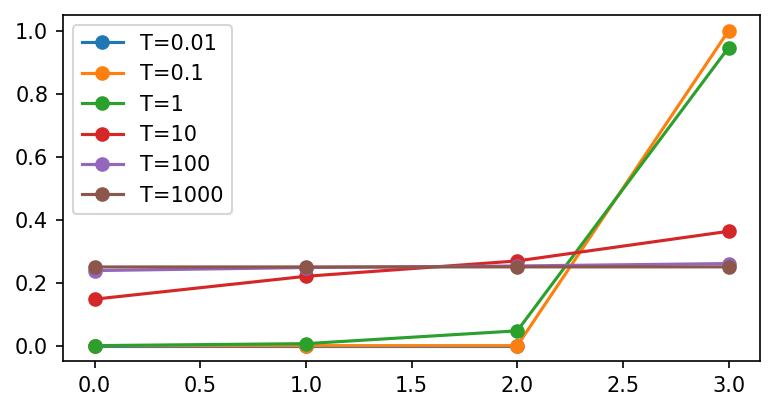

In [4]:
plt.figure(figsize=(6, 3))
logits = np.asarray([1, 5, 7, 10])
Ts = [0.01, 0.1, 1, 10, 100, 10000]
for T in Ts:
    plt.plot(softmax_with_t(logits, T), '-o')
plt.legend(['T=0.01', 'T=0.1', 'T=1', 'T=10', 'T=100', 'T=1000'])

### model.generate

- `do_sample`=True：
- 温度越高，gibberish（乱语），raw token 依然会被采样到；
- 温度越低，coherent（连贯有条理）
    - less weird
    - temperature →0, temperature scaled sampling becomes equal to greedy decoding
- coherence（low temperature） & diversity（high temperature）：trade off

In [5]:
# https://openai.com/research/better-language-models
prompt = 'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.'
input_ids = tokenizer(prompt, return_tensors='pt').input_ids
input_ids

NameError: name 'tokenizer' is not defined